# Networks and Neo4j

## Table of Contents

- [Introduction](#Introduction)
- [Setup](#Setup)

    - [Connecting to the Neo4j Database](#Connecting-to-the-Neo4j-Database)
    - [Testing our connection](#Testing-our-connection)
    
- [Brief Overview of Neo4j and Cypher](#Brief-Overview-of-Neo4j-and-Cypher)

    - [How Neo4j Works](#How-Neo4j-Works)
    - [Components of a Simple Cypher Query](#Components-of-a-Simple-Cypher-Query)
    - [Cypher Query Examples](#Cypher-Query-Examples)
    
- [Using Python to Automate Cypher Tasks](#Using-Python-to-Automate-Cypher-Tasks)

    - [Load in Student Nodes](#Load-in-Student-Nodes)
    - [Create Worked on Relationships with Awards](#Create-Worked-on-Relationships-with-Awards)
    - [Create "Worked With" Relationships Between Students and Staff](#Create-%22Worked-With%22-Relationships-Between-Students-and-Staff)
    
- [Working with Graph Data in `networkx`](#Working-with-Graph-Data-in-networkx)

    - [`networkx` - Plotting Network Graphs](#networkx---Plotting-Network-Graphs)
    - [`networkx` - Network Analysis](#networkx---Network-Analysis)
    
        - [Network Analysis Basics](#Network-Analysis-Basics)
        - [Initializing Example Data](#Initializing-Example-Data)
        - [Metrics - Degree](#Metrics---Degree)
        - [Metrics - Centrality](#Metrics---Centrality)
        - [Metrics - Betweenness](#Metrics---Betweenness)
        - [Cliques](#Cliques)

## Introduction

- back to [Table of Contents](#Table-of-Contents)

This chapter will go over the basics on how to connect to a neo4j database, query the database, and analyse data.  This file, `networks_with_neo4j.ipynb`, is the first notebook you should run.  Then, you can open and work through an exercise involving neo4j in the notebook `networks_exercise.ipynb`.

Before you begin this lesson:

* Read through and make sure you've followed all the steps in the file README.md inside this exercise's folder.
* Read though the "Installing neo4j" Guide (either the PDF or the Word Document).
* Start your neo4j server using the "Ne04j Community Edition" application on your computer (you can confirm it is running by opening [http://localhost:7474/](http://localhost:7474/) - if neo4j is running, you'll either get the "$" prompt or be asked to log in.  If neo4j is not running, you'll get an error message indicating the page cannot load).

## Setup

- back to [Table of Contents](#Table-of-Contents)

First, we'll import python packages needed for the code in this notebook.  If you stop in the middle of this notebook, close it, then come back later to continue, make sure to run these imports each time you start up the notebook again.

In [1]:
# Imports 
import sys

# import six for python 2 and 3 support.
import six

# py2neo - Python package for interacting with neo4j.
import py2neo

import pymysql
import numpy
import pprint
import pandas
import networkx

# Allows plots to be showed inline 
import matplotlib
%matplotlib inline

import datetime
print( "--COMPLETE-- at " + str( datetime.datetime.now() ) )

--COMPLETE-- at 2016-09-29 11:58:52.376205


### Connecting to the Neo4j Database 

- back to [Table of Contents](#Table-of-Contents)

To connect to the Neo4j Database we will be using the `py2neo` Python package ( [http://py2neo.org](http://py2neo.org) ).

In the cell below we will begin by using `py2neo` to create a connection to our neo4j database. 

In [8]:
# Set up connection to Neo4j local Database 
# You will need to authenticate your connection, use the next line as an example 
# authenticate("localhost:7474", "<YOUR USENAME HERE>, Default is: neo4j", "<YOUR_PASSWORD_HERE>")

# set up authentication parameters
database_host = "localhost"
database_port = "7474"
database_username = "neo4j"
database_password = "Leonardo1991"

# authenticate with "py2neo.authenticate()" function.
py2neo.authenticate( database_host + ":" + database_port, database_username, database_password )

# Create a variable for our graph and print our connection infomation
graph_db = py2neo.Graph()
print( "Connection to Neo4j at " + str( graph_db ) + " created at " + str( datetime.datetime.now() ) )


Connection to Neo4j at <Graph uri='http://localhost:7474/db/data/'> created at 2016-09-29 12:01:18.429027


### Testing our connection

- back to [Table of Contents](#Table-of-Contents)

To extract data from our database, we will pass cypher commands Neo4j using the `data()` method on an instance of py2neo's Graph object (more details on this follow).

More details on this follow.  First, however, to test our connection, we'll use the `data()` method to run a basic cypher query that asks Neo4j to find all nodes:

    MATCH (n)

but return only one:

    RETURN n limit 1;

In [9]:
# The syntax below translates to,
#'Match (Find) any node, lets call it "node", and show me its data. Limit the results to 1'

graph_db.data( "MATCH ( node ) RETURN node limit 1;" )

[{'node': (f34bdfa:Employee {employeeid:"90014540",position:"FACULTY"})}]

## Brief Overview of Neo4j and Cypher

- back to [Table of Contents](#Table-of-Contents)

### How Neo4j Works

- back to [Table of Contents](#Table-of-Contents)

When you think of data, you probably imagine an excel table where each row is an individual observation or data point. 

For example:

|name | age | employee_id|
|-----|-----|------------|
|Joe  |  34 |   12345    |
|Ann  |  54 |   12346    |
    
In Neo4j, each of these rows is stored as and referred to as a Node.  Neo4j nodes can contain all the same information as a tabular representation of data like a spreadsheet or a traditional database table, but they are structured a little differently.

A traditional database table will have a set number of columns, and each row in the table will have the same set of columns.  Different types of data are stored in different tables, and rows within a given table can not have different sets of values.

In Neo4j (and in other "NoSQL" databases that use a record model rather than a relational table model), all things in the system are placed in a single "Node" database, and each can have any properties you want to assign to them.

So, where a relational database might have separate tables for students and employees, for example, in Neo4j, students and employees are both stored as nodes, and the properties of the node are set as is appropriate for the type of node (so employees have name, age, and an employee ID - just like in the example table above - and students might have name, age, major, expected graduation date, and student ID).

You can (and should!) have types of nodes that all are expected to have the same set of properties, but Neo4j and other NoSQL databases do not formally require this like a relational database does when you place data into a table.

For example, when you run the following query using py2neo:

    MATCH ( n ) RETURN n LIMIT 1;
    
You get back the following:

    [{'n': (b63c693:Employee {employeeid:"90014540",position:"FACULTY"})}]
    
OR, formatted more politely:

    [
        {
            'n': (
                b63c693 : Employee {
                    employeeid:"90014540",
                    position:"FACULTY"
                }
            )
            
        }
    ]
    
This structure uses Python (and JSON) conventions for lists and dictionaries to tell you that it returns:

- a list ( the outer "[]" )
- of dictionaries ( the "{}" inside the list )
- each entry of which contains a mapping of one of the sets of nodes you've requested in RETURN (in this case, 'n')
- to a static list (inside the parentheses - "()") of the matching nodes that maps IDs (example: `b63c693`) to node properties (`Employee {employeeid:"90014540",position:"FACULTY"}`).

The information about an employee is still there (well, other than the name since we've removed it from our data set...), but instead of storing each peice of information on an employee in a pre-defined column, each employee's information is stored as **properties** on a node, and the type of node is captured as a **label**, *Employee*, associated with the node that identify it as being of type "Employee".

### Components of a Simple Cypher Query

- back to [Table of Contents](#Table-of-Contents)

Neo4j uses the Cypher Query Language to get information out of the Database.  The basic syntax is "`MATCH ( n ) RETURN n LIMIT 1;`":

+ MATCH ( n )

    - The `MATCH` clause is essentially the same as the SELECT clause in SQL.  It tells the Cypher query that you are filtering, and the information in parentheses defines where the query will be looking.
    - `( n )` tells the Cypher Query to filter and retrieve matches from all nodes.  In `MATCH`, the letter you place here is a name you'll use in subsequent parts of the query to refer to matching nodes (like the `AS` keyword in SQL).  It can be any name, does not need to be `n`.
    - Simply placing a name here means it will look at all nodes, regardless of type/label.  To filter on a label, append the label after the name, separated by a colon.  So, for nodes of type "Employee", your `MATCH` would look something like: `MATCH ( employees : Employee )`
    - You can place more than one type of node inside the parentheses of a `MATCH` clause.

+ RETURN n

    - The `RETURN` clause tells the Cypher query what information should be returned for matching nodes.
    - If you just return the name of the node specified in `MATCH ()`, then it will return all properties for each node.
    - You can also specify the names of specific properties of nodes ( "`RETURN n.employeeid, n.position`", for example).
    - A `RETURN` clause is needed in every query.

+ LIMIT 1     

    - LIMIT lets you request a subset of all matches be returned (in this case, just 1).  This does not imply order, so you might get a different node each time you run this query.
    - This is similar to the LIMIT clause in an SQL statement.
    
+ all Cypher queries end with a semi-colon ( ";" ).

The following query will return 20 nodes from the database:  

    graph_db.data( "MATCH ( node ) RETURN node LIMIT 20;" )

If I wanted to query just nodes of type "Award" (where types are signified by labels associated with nodes), I would add a filter for the label "Award" inside the MATCH clause ( `MATCH ( n : Award )` ):  

    graph_db.data( "MATCH ( awards : Award ) RETURN awards LIMIT 20;" )

In [10]:
# You can use this cell to Test the Cypher Queries.  For example, let's try to:
# - Match (Find) any nodes that are of type Award
# - and show the award number (award_num) for each of the nodes returned,
# - limiting the number of results to 20.

graph_db.data( "MATCH ( awards : Award ) RETURN awards.award_num LIMIT 20;" )

[{'awards.award_num': 'aw1000'},
 {'awards.award_num': 'aw1001'},
 {'awards.award_num': 'aw1002'},
 {'awards.award_num': 'aw1003'},
 {'awards.award_num': 'aw1004'},
 {'awards.award_num': 'aw1005'},
 {'awards.award_num': 'aw1006'},
 {'awards.award_num': 'aw1007'},
 {'awards.award_num': 'aw1008'},
 {'awards.award_num': 'aw1009'},
 {'awards.award_num': 'aw1010'},
 {'awards.award_num': 'aw1011'},
 {'awards.award_num': 'aw1012'},
 {'awards.award_num': 'aw1013'},
 {'awards.award_num': 'aw1014'},
 {'awards.award_num': 'aw1015'},
 {'awards.award_num': 'aw1016'},
 {'awards.award_num': 'aw1017'},
 {'awards.award_num': 'aw1018'},
 {'awards.award_num': 'aw1019'}]

### Cypher Query Examples 

- back to [Table of Contents](#Table-of-Contents)

The below are some examples of different cypher commands executed using py2neo.

Note: The object returned by Py2neo is a neted list of dictonaries where each dictonary represents a single node.

In [11]:
# Collect 20 Employee Nodes 

# The syntax below translates to, 
#'Match(Find) any nodes of type Employee 
# then show me the employee ID (employeeid) of the employee nodes. Limit the results to 20'
node_query_single =  graph_db.data( "MATCH ( e : Employee ) RETURN e.employeeid LIMIT 20;" )

pprint.pprint( node_query_single )

[{'e.employeeid': '90014540'},
 {'e.employeeid': '90026679'},
 {'e.employeeid': '90017693'},
 {'e.employeeid': '90028696'},
 {'e.employeeid': '90013819'},
 {'e.employeeid': '90001118'},
 {'e.employeeid': '90001300'},
 {'e.employeeid': '90023086'},
 {'e.employeeid': '90017074'},
 {'e.employeeid': '90025003'},
 {'e.employeeid': '90000321'},
 {'e.employeeid': '90001779'},
 {'e.employeeid': '90012327'},
 {'e.employeeid': '6663'},
 {'e.employeeid': '90028695'},
 {'e.employeeid': '90013011'},
 {'e.employeeid': '90004139'},
 {'e.employeeid': '90002533'},
 {'e.employeeid': '90022882'},
 {'e.employeeid': '90027179'}]


In [12]:
# Collect 20 Award Nodes and 20 employee Nodes 

# The syntax below translates to, 
#'Match (Find) any nodes that are of type Award and Match(Find) any nodes of type Employee 
# then show me the award number (award_num) of the award nodes 
# and the employee ID (employeeid) of the employee nodes. Limit the results to 20'
node_query_multiple =  graph_db.data("MATCH ( a : Award ), ( e : Employee ) RETURN a.award_num, e.employeeid LIMIT 20;" )

pprint.pprint(node_query_multiple )

[{'a.award_num': 'aw1000', 'e.employeeid': '90014540'},
 {'a.award_num': 'aw1001', 'e.employeeid': '90014540'},
 {'a.award_num': 'aw1002', 'e.employeeid': '90014540'},
 {'a.award_num': 'aw1003', 'e.employeeid': '90014540'},
 {'a.award_num': 'aw1004', 'e.employeeid': '90014540'},
 {'a.award_num': 'aw1005', 'e.employeeid': '90014540'},
 {'a.award_num': 'aw1006', 'e.employeeid': '90014540'},
 {'a.award_num': 'aw1007', 'e.employeeid': '90014540'},
 {'a.award_num': 'aw1008', 'e.employeeid': '90014540'},
 {'a.award_num': 'aw1009', 'e.employeeid': '90014540'},
 {'a.award_num': 'aw1010', 'e.employeeid': '90014540'},
 {'a.award_num': 'aw1011', 'e.employeeid': '90014540'},
 {'a.award_num': 'aw1012', 'e.employeeid': '90014540'},
 {'a.award_num': 'aw1013', 'e.employeeid': '90014540'},
 {'a.award_num': 'aw1014', 'e.employeeid': '90014540'},
 {'a.award_num': 'aw1015', 'e.employeeid': '90014540'},
 {'a.award_num': 'aw1016', 'e.employeeid': '90014540'},
 {'a.award_num': 'aw1017', 'e.employeeid': '9001

In [13]:
# Return 20 relationships where an Employee worked on an Award

# The syntax below translates to, 
#'Match (Find) any instances of a node of type Award connected to a node of type employee. 
# For each relationship found, return the award number and the employee id of the nodes in that relationship. 
# also return the relationship type, 'WORKED_ON'
#Limit the results to 20'
relationsip_query = graph_db.data("MATCH (a:Award) <-[r:WORKED_ON]- (e:Employee) RETURN a.award_num,e.employeeid,type(r) LIMIT 20")

pprint.pprint( relationsip_query )

[{'a.award_num': 'aw1000', 'e.employeeid': '90014540', 'type(r)': 'WORKED_ON'},
 {'a.award_num': 'aw1001', 'e.employeeid': '90026679', 'type(r)': 'WORKED_ON'},
 {'a.award_num': 'aw1002', 'e.employeeid': '90017693', 'type(r)': 'WORKED_ON'},
 {'a.award_num': 'aw1003', 'e.employeeid': '90028696', 'type(r)': 'WORKED_ON'},
 {'a.award_num': 'aw1004', 'e.employeeid': '90013819', 'type(r)': 'WORKED_ON'},
 {'a.award_num': 'aw1005', 'e.employeeid': '90001118', 'type(r)': 'WORKED_ON'},
 {'a.award_num': 'aw1006', 'e.employeeid': '90001300', 'type(r)': 'WORKED_ON'},
 {'a.award_num': 'aw1007', 'e.employeeid': '90023086', 'type(r)': 'WORKED_ON'},
 {'a.award_num': 'aw1145', 'e.employeeid': '90023086', 'type(r)': 'WORKED_ON'},
 {'a.award_num': 'aw1476', 'e.employeeid': '90023086', 'type(r)': 'WORKED_ON'},
 {'a.award_num': 'aw1008', 'e.employeeid': '90017074', 'type(r)': 'WORKED_ON'},
 {'a.award_num': 'aw1146', 'e.employeeid': '90017074', 'type(r)': 'WORKED_ON'},
 {'a.award_num': 'aw1477', 'e.employeeid

In [14]:
# Pattern Query 

# Retrun 20 instances of the pattern where two employees worked on the same award. Return only the employeeid of each employee  

# The syntax below translates to, 
# 'Match (Find) any instances of two nodes of type employee having a relationship with a node of type award.
# Return the employeeid of each of the employee nodes in that relationship.
# Also, return the award number of the award in the relationship.  
# Limit the results to 20'
pattern_query = graph_db.data("MATCH (e1:Employee) --> (a:Award) <-- (e2:Employee) RETURN e1.employeeid, e2.employeeid, a.award_num LIMIT 20")

pprint.pprint( pattern_query )

[{'a.award_num': 'aw1003',
  'e1.employeeid': '90000919',
  'e2.employeeid': '90028696'},
 {'a.award_num': 'aw1004',
  'e1.employeeid': '90024693',
  'e2.employeeid': '90013819'},
 {'a.award_num': 'aw1005',
  'e1.employeeid': '90001652',
  'e2.employeeid': '90001118'},
 {'a.award_num': 'aw1006',
  'e1.employeeid': '90025754',
  'e2.employeeid': '90001300'},
 {'a.award_num': 'aw1007',
  'e1.employeeid': '90004472',
  'e2.employeeid': '90023086'},
 {'a.award_num': 'aw1007',
  'e1.employeeid': '90026898',
  'e2.employeeid': '90023086'},
 {'a.award_num': 'aw1007',
  'e1.employeeid': '90022371',
  'e2.employeeid': '90023086'},
 {'a.award_num': 'aw1145',
  'e1.employeeid': '90029620',
  'e2.employeeid': '90023086'},
 {'a.award_num': 'aw1008',
  'e1.employeeid': '90028781',
  'e2.employeeid': '90017074'},
 {'a.award_num': 'aw1008',
  'e1.employeeid': '90004472',
  'e2.employeeid': '90017074'},
 {'a.award_num': 'aw1008',
  'e1.employeeid': '90024665',
  'e2.employeeid': '90017074'},
 {'a.award

## Using Python to Automate Cypher Tasks 

- back to [Table of Contents](#Table-of-Contents)

An advantage of using python to interface with neo4j is that you can send commands to neo4j in a saved and reproducable manner. In theory, all the work we did copying and pasting commands into neo4j in the instalation chapter can be replaced with python commands.

To demonstrate this we will add some new Nodes and Relationships to our graph.

Roke College prides itself on providing research opportunities for its Students. Students are often employed by the university to provide research assistance to faculty members on the awards they work on. 

To fully add the Students to the database we will need to:

1. Create a variable setting the location of our files. This is the directory
    where your student_data.csv and award_data.csv files are saved.  By default, we place our data for import in the `import` directory inside our Neo4j database file, so we leave this variable empty.
2. Load in the student nodes via a csv file 
3. Create a WORKED_ON relationship between the students and the awards on which they work
4. Createa WORKED_WITH relationship between students and their peers who worked on the same awards 
    

_NOTE:_

_You may notice that here we are using the MERGE command instead of the CREATE command to create relationships. This is done to prevent duplicate nodes and relationships from being created. A CREATE command will create a new node or relationship regardless of whether that entitiy already exsists. The MERGE command will create that node or relationship only if it does not already exist._


### Load in Student Nodes

- back to [Table of Contents](#Table-of-Contents)

In [15]:
# Store data directory path for re-use
data_directory_path = ""

# The syntax below translates to, 
#'Load the file at the location <File Path>.
# For each row in that data, create a node of type Student with the properties employeeid and position

# Build the Cypher Query string.
cypher_string = '''USING PERIODIC COMMIT
LOAD CSV WITH HEADERS FROM \"file://'''
cypher_string += data_directory_path
cypher_string += '''/student_data.csv\"
AS row CREATE (:Student {employeeid: row.employeeid, position: row.occupation_orig});'''

# run the Cypher Query.
graph_db.data( cypher_string )

print( "--COMPLETE-- at " + str( datetime.datetime.now() ) )

--COMPLETE-- at 2016-09-29 12:02:02.693010


### Create Worked on Relationships with Awards

- back to [Table of Contents](#Table-of-Contents)

In [16]:
# The syntax below translates to, 
#'Load the file at the location <File Path>.
# For each row in the file, find the Award node and Student node that corespond to the 
# arard_num and employeeid in that row.
# if there is not already a WORKED_ON relationship between the two, create one. 

# Build the Cypher Query string.
cypher_string = '''USING PERIODIC COMMIT
LOAD CSV WITH HEADERS FROM \"file://'''
cypher_string += data_directory_path
cypher_string += '''/award_data.csv" AS row
MATCH (a:Award {award_num: row.uniqueawardnumber})
MATCH (s:Student {employeeid: row.employeeid})
MERGE (s)-[r:WORKED_ON]->(a);'''

# run the Cypher Query.
graph_db.data( cypher_string )

print( "--COMPLETE-- at " + str( datetime.datetime.now() ) )

--COMPLETE-- at 2016-09-29 12:02:07.168163


### Create "Worked With" Relationships Between Students and Staff

- back to [Table of Contents](#Table-of-Contents)

In [17]:
# The syntax below translates to, 
# Find the instances where two nodes have a WORKED_ON relationship with an Award node,
# if there is not a 'WORKED_WITH' relationship between the two, create one. 

# Build the Cypher query string
cypher_string = '''MATCH (n1)-[:WORKED_ON]->(a:Award)<-[:WORKED_ON]-(n2)
MERGE (n1)-[r:WORKED_WITH]-(n2);'''

# run the Cypher query
graph_db.data( cypher_string )

print( "--COMPLETE-- at " + str( datetime.datetime.now() ) )

--COMPLETE-- at 2016-09-29 12:02:10.540948


If you would like to see the new data, open your neo4j console. you'll see that we now have a new node label, Student. 

## Working with Graph Data in `networkx`

- back to [Table of Contents](#Table-of-Contents)

### `networkx` - Plotting Network Graphs 

- back to [Table of Contents](#Table-of-Contents)

Networkx is a python modual for creating, displaying and analysing graph data. 

We can load data from our neo4j graph into networkx by preforming queries and passing that data to networkx.

Run the cell below to see an example

   a.award_num p.employeeid  weight
0       aw1000     90014540    0.01
1       aw1001     90026679    0.01
2       aw1002     90017693    0.01
3       aw1003     90028696    0.01
4       aw1003     90000919    0.01
5       aw1004     90013819    0.01
6       aw1004     90024693    0.01
7       aw1005     90001118    0.01
8       aw1005     90001652    0.01
9       aw1006     90039108    0.01
10      aw1006     90001300    0.01
11      aw1006     90025754    0.01
12      aw1007     90023086    0.01
13      aw1007     90004472    0.01
14      aw1007     90026898    0.01
15      aw1007     90022371    0.01
16      aw1008     90017074    0.01
17      aw1008     90028781    0.01
18      aw1008     90004472    0.01
19      aw1008     90024665    0.01
20      aw1009     90025003    0.01
21      aw1009     98101941    0.01
22      aw1009     90028781    0.01
23      aw1009     90002437    0.01
24      aw1010     90000321    0.01
25      aw1010     90001461    0.01
26      aw1010     98101941 

'\nNotes \nGreen Nodes are Employees\nYellow Nodes are Students\nRed Nodes are Awards\n\n'

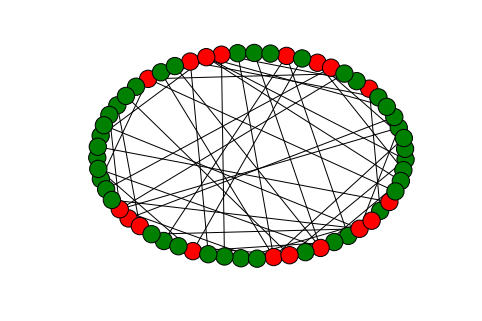

In [18]:
# Preform a cypher query to get 50 instances where a person worked on an award
results = graph_db.data("MATCH (p) -[r]-> (a:Award) RETURN p.employeeid, a.award_num LIMIT 50")

# Convert The results to a dataframe 
results_df =pandas.DataFrame(results)

# This will make  the connections between the nodes easier to see 
results_df['weight'] = .01

# Uncomment this next line if you would like to see what the data looks like 
print(pandas.DataFrame(results_df))

# Convert to graph object
graph = networkx.from_pandas_dataframe(results_df, 'p.employeeid', 'a.award_num', ['weight'])


# The following code is used to keep track of employees vs. award numbers,
# and then to assign colors to nodes of each type in the graph
emps = {}
awards = {} 
color_vals = []

for pair in results:
    emps[pair["p.employeeid"]] = 1
    awards[pair["a.award_num"]] = 1


for node in graph.nodes(data =True):
    if node[0] in emps:
        color_vals.append ('g')  # green
    else:
        color_vals.append ('r')  # red

    
# Draw the graph 
networkx.draw(graph, node_color = color_vals)

"""
Notes 
Green Nodes are Employees
Yellow Nodes are Students
Red Nodes are Awards

"""

### `networkx` - Network Analysis 

- back to [Table of Contents](#Table-of-Contents)

The networkx module also has built in tools to analyse graphs. The following measurements are used to assess how the nodes are related to each other in the graph database.  

#### Network Analysis Basics 

- back to [Table of Contents](#Table-of-Contents)

In network analysis:

- **_nodes_** are the things in a network that are related to each other
- **_edges_** or **_ties_** are relations between nodes.
- **_metrics_** are statistical scores that can be calculated on nodes or networks as a whole to describe characteristics of a node or of the broader network.

The following are some examples of traits of individual nodes and the overall network in a network graph that can be used to characterize network data:

- **Degree Centrality ** - counts the number of edges that an individual node has 

    - Nodes with a high degree of connections usually play an important role in a network
    - This can also be looked at in aggregate for all nodes in a graph to get an idea of the overall connectedness of the graph.  For example, calculate the mean and median degree centrality across all nodes to look at how connected a graph is, in general.

- **Betweenness ** - indicator of a node's centality in a network. 

    - Equal to the number of shortest paths from all vertices to all others that pass through that node
    - This also can be looked at in aggregate to characterize an entire network.

- **Diameter** - The longest shortest path over all pairs of nodes 

    - Often we want to find the shortest distance between two nodes; the diameter is the longest of these paths 
     - Nodes that occur on many shortest paths between other nodes in the graph have a high betweenness centrality score

- **Cliques ** - A clique is a subset of vertices of an undirected graph such that every two distinct vertices in the clique are adjacent.     

Let's look at how we'd use `networkx` to calculate these measures in a sample set of data.

#### Initializing Example Data

- back to [Table of Contents](#Table-of-Contents)

Run the Cell Below to create one of Networkx eample graphs, the Maze Graph

Tuttle Graph
-------------
Number of Nodes: 8


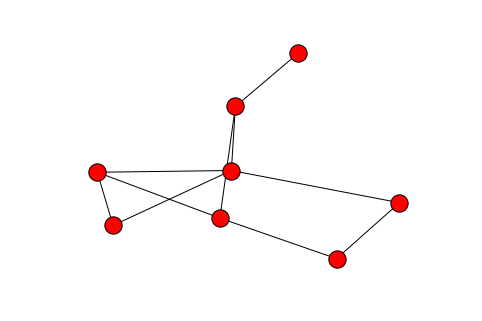

In [19]:
# Create The graph
maze=networkx.sedgewick_maze_graph()

# Draw the graph
networkx.draw(maze)

print( "Tuttle Graph" )
print( "-------------" )
print( "Number of Nodes: " + str( maze.number_of_nodes() ) )

#### Metrics - Degree

- back to [Table of Contents](#Table-of-Contents)

The "Degree" metric:

- Counts the number of edges that a node has 
- Nodes with a high degree of connections usally play an important role in a network 

In [20]:
# Calculate the degree of each node 

# get map of node IDs to degree for each node.
maze_degree_dict = maze.degree()

# get an iterator over just the values.
maze_degree_values = six.itervalues( maze_degree_dict )

# convert to a list for min() and max()
degree_value_list = list( maze_degree_values )

# convert to numpy array for numpy.mean() and numpy.median()
numpy_degree_value_array = numpy.array( degree_value_list )

# calculate min, max, mean, and median values:
degree_min = min( degree_value_list )
degree_max = max( degree_value_list )
degree_mean = numpy.mean( numpy_degree_value_array )
degree_median = numpy.median( numpy_degree_value_array )

# output:
print( "The Minimum number of Edges = " + str( degree_min ) )
print( "The Minimum number of Edges = " + str( degree_max ) )
print( "The Mean number of Edges = " + str( degree_mean ) )
print( "The Median number of Edges = " + str( degree_median ) )

The Minimum number of Edges = 1
The Minimum number of Edges = 4
The Mean number of Edges = 2.5
The Median number of Edges = 2.5


#### Metrics - Centrality

- back to [Table of Contents](#Table-of-Contents)

"Centrality" metrics use different methods to calculate how central a given node is within a network, or how centralized a given network graph is.

In [21]:
# Normalized degree is degree centrality divided by the maximum possible number of connections 
# The bigger the number, the more connections 

# Calculate the degree centrality of each node 

# get map of node IDs to degree centrality values for each node.
maze_degree_centrality_dict = networkx.degree_centrality( maze )

# get an iterator over just the values.
maze_degree_centrality_values = six.itervalues( maze_degree_centrality_dict )

# convert to a list for min() and max()
degree_centrality_value_list = list( maze_degree_centrality_values )

# convert to numpy array for numpy.mean() and numpy.median()
numpy_degree_centrality_value_array = numpy.array( degree_centrality_value_list )

# calculate min, max, mean, and median values:
degree_centrality_min = min( degree_centrality_value_list )
degree_centrality_max = max( degree_centrality_value_list )
degree_centrality_mean = numpy.mean( numpy_degree_centrality_value_array )
degree_centrality_median = numpy.median( numpy_degree_centrality_value_array )

# output:
print( "The Minimum Degree Centrality = " + str( degree_centrality_min ) )
print( "The Minimum Degree Centrality = " + str( degree_centrality_max ) )
print( "The Mean Degree Centrality = " + str( degree_centrality_mean ) )
print( "The Median Degree Centrality = " + str( degree_centrality_median ) )

The Minimum Degree Centrality = 0.14285714285714285
The Minimum Degree Centrality = 0.5714285714285714
The Mean Degree Centrality = 0.357142857143
The Median Degree Centrality = 0.357142857143


In [22]:
# Freeman Centralization:
# How much variation is there in the centrality scores among the nodes?
# http://cs.brynmawr.edu/Courses/cs380/spring2013/section02/slides/05_Centrality.pdf
# Scores closer to one convey more popular nodes interact with many other nodes; 
# the closer to zero, the more interactions between nodes are evenly distributed 

# Calculate the centralization for all the nodes 
all_degrees = maze.degree().values()

# Get the Maximum degree number 
max_degree = max(all_degrees)
# Get the number of nodes in the maze graph
nodes_num = maze.number_of_nodes()

# Calculate the centrality using the max degree, the number of nodes, and the degrees of all then node
centrality = sum([max_degree - x for x in all_degrees]) / float(((nodes_num - 1)*(nodes_num - 2)))
print( "The Centrility of this graph is " + str( centrality ) )

The Centrility of this graph is 0.2857142857142857


### Metrics - Betweenness

- back to [Table of Contents](#Table-of-Contents)

**_Betweenness_** equals the number of shortes paths from all vertices to all others that pass through a given node.

In [23]:
# Calulate Betweenness Centrality scores for all the nodes

# get map of node IDs to betweenness centrality for each node.
betweenness_centrality_dict = networkx.betweenness_centrality(maze)

# get an iterator over just the values.
betweenness_centrality_values = six.itervalues( betweenness_centrality_dict )

# convert to a list for min() and max()
centrality_value_list = list( betweenness_centrality_values )

# convert to numpy array for numpy.mean() and numpy.median()
numpy_centrality_value_array = numpy.array( centrality_value_list )

# calculate min, max, mean, and median values:
between_centrality_min = min( centrality_value_list )
between_centrality_max = max( centrality_value_list )
between_centrality_mean = numpy.mean( numpy_centrality_value_array )
between_centrality_median = numpy.median( numpy_centrality_value_array )

# output:
print( "The Minimum Betweenness measure = " + str( between_centrality_min ) )
print( "The Minimum Betweenness measure = " + str( between_centrality_max ) )
print( "The Mean Betweenness measure = " + str( between_centrality_mean ) )
print( "The Median Betweenness measure = " + str( between_centrality_median ) )

The Minimum Betweenness measure = 0.0
The Minimum Betweenness measure = 0.3571428571428571
The Mean Betweenness measure = 0.136904761905
The Median Betweenness measure = 0.0833333333333


#### Metrics - Diameter

- back to [Table of Contents](#Table-of-Contents)

Often we want to find the shortest distance between two nodes in a network graph; the **_diameter_** is the longest of theses paths.

- Nodes that occur on many of these shortest paths between other nodes in the graph have a high betweenness centrality score  

In [24]:
diameter_size = networkx.diameter(maze)
print( "The Diameter of this graph is " + str(diameter_size) )


The Diameter of this graph is 3


#### Cliques

- back to [Table of Contents](#Table-of-Contents)

A **_clique_** is a subset of vertices of an undirected graph such that every two distinct vertices in the clique are adjacent.  

In [25]:
maze_cliques =  list(networkx.find_cliques(maze))
print( "The Cliques in the Maze graph are, " + str(maze_cliques) )

The Cliques in the Maze graph are, [[0, 2], [0, 5], [0, 7], [1, 7], [2, 6], [4, 3, 5], [4, 6], [4, 7]]


**The above list of cliques are a somewhat unintresting.**

Run the code cell below to see the clique list of another built-in graph, the lolipop graph.

You can see that the lollipop graph has a cluster of 10 nodes that make up the "candy" part of the lollipop while the "stem" of the lollipop is a line of nodes.

The Cliques in the Lollipop graph are, [[9, 0, 1, 2, 3, 8, 4, 5, 6, 7], [9, 10], [11, 10], [11, 12], [12, 13], [13, 14], [14, 15], [15, 16], [16, 17], [17, 18], [18, 19], [19, 20], [20, 21], [21, 22], [22, 23], [23, 24], [24, 25], [25, 26], [26, 27], [27, 28], [28, 29]]


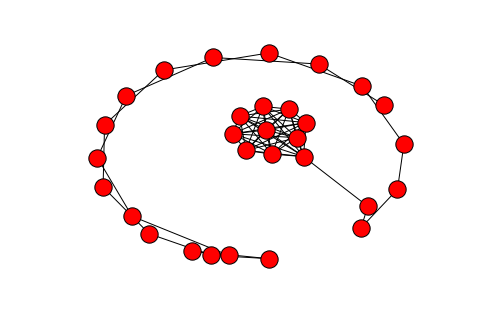

In [26]:
# Create the Graph 
lolli_g = lollipop=networkx.lollipop_graph(10,20)

# Get the cliques of the graph 
lolli_cliques = list(networkx.find_cliques(lolli_g))

print( "The Cliques in the Lollipop graph are, " + str(lolli_cliques) )

# Draw the Graph
networkx.draw(lolli_g)